In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV


class LinearModelForecaster:
    def __init__(self, data_path, target_col, model_type='linear', lags=list(range(1, 13))):
        self.data_path = data_path
        self.target_col = target_col
        self.lags = lags
        self.model_type = model_type
        self.df = None
        self.scaler = StandardScaler()
        self.model = None
        self.X_train = self.X_test = self.y_train = self.y_test = None

    def load_data(self):
        self.df = pd.read_csv(self.data_path, parse_dates=['time'], index_col='time')
        self.df[self.target_col] = self.scaler.fit_transform(self.df[[self.target_col]])
        for lag in self.lags:
            self.df[f'lag_{lag}'] = self.df[self.target_col].shift(lag)
        self.df.dropna(inplace=True)

    def prepare_data(self, test_size=12):
        X = self.df[[f'lag_{lag}' for lag in self.lags]].values
        y = self.df[self.target_col].values
        self.X_train, self.X_test = X[:-test_size], X[-test_size:]
        self.y_train, self.y_test = y[:-test_size], y[-test_size:]

    def build_model(self):
        if self.model_type == 'linear':
            model = LinearRegression()
        elif self.model_type == 'ridge':
            param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
            model = GridSearchCV(Ridge(), param_grid, scoring='neg_mean_squared_error', cv=3)
        elif self.model_type == 'lasso':
            param_grid = {'alpha': [0.001, 0.01, 0.1, 1]}
            model = GridSearchCV(Lasso(max_iter=10000), param_grid, scoring='neg_mean_squared_error', cv=3)
        elif self.model_type == 'elasticnet':
            param_grid = {'alpha': [0.001, 0.01, 0.1, 1], 'l1_ratio': [0.1, 0.5, 0.9]}
            model = GridSearchCV(ElasticNet(max_iter=10000), param_grid, scoring='neg_mean_squared_error', cv=3)
        else:
            raise ValueError("Unsupported model type")
        return model

    def forecast(self, steps=12, start_sequence=None):
        if self.model is None:
            raise ValueError("Model not trained. Run `run()` first.")
        if start_sequence is None:
            raise ValueError("Start sequence must be provided.")
        sequence = start_sequence.flatten()
        forecasts = []
        for _ in range(steps):
            pred = self.model.predict(sequence.reshape(1, -1))
            forecasts.append(pred[0])
            sequence = np.roll(sequence, -1)
            sequence[-1] = pred
        return self.scaler.inverse_transform(np.array(forecasts).reshape(-1, 1)).flatten()

    def plot_results(self, y_test, predictions, forecasts):
        plt.figure(figsize=(10, 6))
        plt.plot(y_test, label='Actual')
        plt.plot(predictions, label='Predicted')
        plt.plot(forecasts, label='Forecasted', linestyle='--')
        plt.title(f'{self.model_type.capitalize()} Regression Forecast')
        plt.xlabel('Time Step')
        plt.ylabel(self.target_col)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def run(self, test_size=12):
        self.load_data()
        self.prepare_data(test_size)
        self.model = self.build_model()
        self.model.fit(self.X_train, self.y_train)
        if hasattr(self.model, 'best_params_'):
            print("Best Params:", self.model.best_params_)

        predictions = self.model.predict(self.X_test)
        y_test_actual = self.scaler.inverse_transform(self.y_test.reshape(-1, 1)).flatten()
        predictions_actual = self.scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

        forecasts = self.forecast(steps=test_size, start_sequence=self.X_train[-1:])

        # Evaluation
        print("Prediction Metrics (Test Set):")
        print(f"RMSE: {np.sqrt(mean_squared_error(y_test_actual, predictions_actual)):.4f}")
        print(f"MAE: {median_absolute_error(y_test_actual, predictions_actual):.4f}")
        print(f"MAPE: {mean_absolute_percentage_error(y_test_actual, predictions_actual) * 100:.2f}%")

        print("\nForecast Metrics:")
        print(f"RMSE: {np.sqrt(mean_squared_error(y_test_actual, forecasts)):.4f}")
        print(f"MAE: {median_absolute_error(y_test_actual, forecasts):.4f}")
        print(f"MAPE: {mean_absolute_percentage_error(y_test_actual, forecasts) * 100:.2f}%")

        self.plot_results(y_test_actual, predictions_actual, forecasts)
        return predictions_actual, forecasts


C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2875198722.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2875198722.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2875198722.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2875198722.py:61:

Prediction Metrics (Test Set):
RMSE: 0.4317
MAE: 0.3963
MAPE: 0.34%

Forecast Metrics:
RMSE: 1.6459
MAE: 0.9595
MAPE: 1.28%


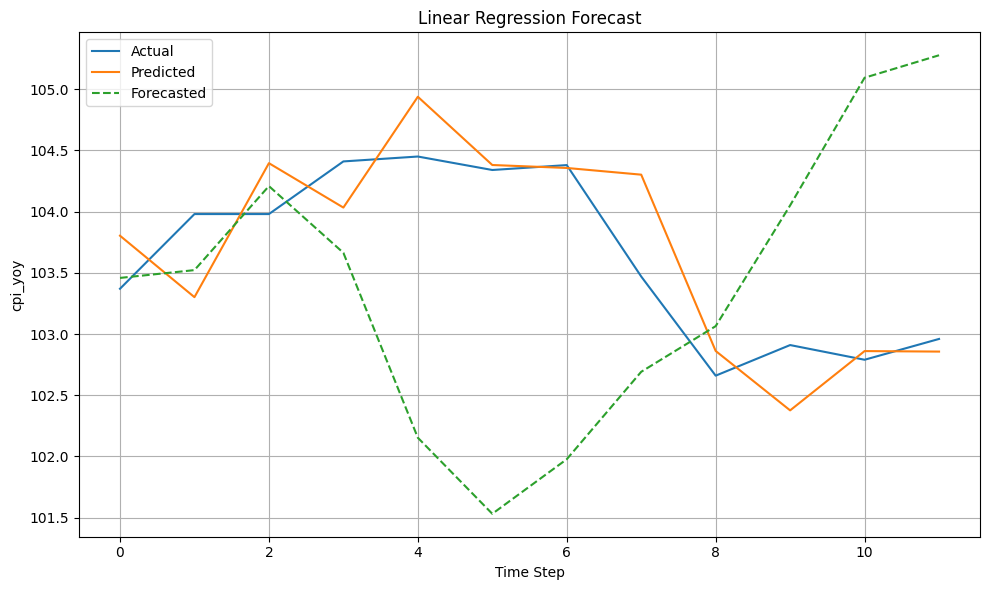

Best Params: {'alpha': 0.01}
Prediction Metrics (Test Set):
RMSE: 0.4311
MAE: 0.3916
MAPE: 0.34%

Forecast Metrics:
RMSE: 1.6462
MAE: 0.9614
MAPE: 1.28%


C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2875198722.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2875198722.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2875198722.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2875198722.py:61:

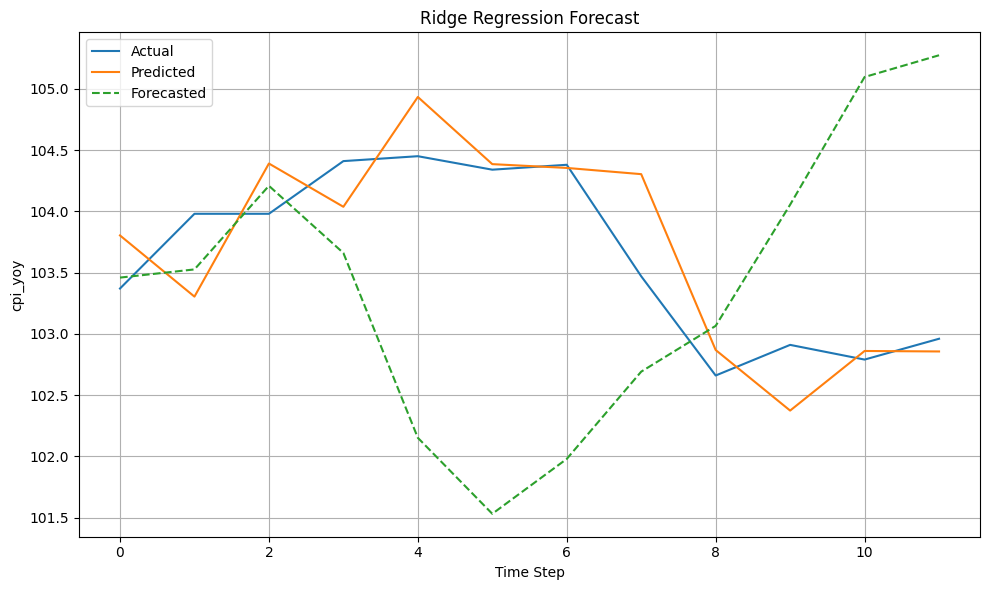

Best Params: {'alpha': 0.001}
Prediction Metrics (Test Set):
RMSE: 0.4536
MAE: 0.3405
MAPE: 0.37%

Forecast Metrics:
RMSE: 1.6252
MAE: 1.1272
MAPE: 1.28%


C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2875198722.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2875198722.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2875198722.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2875198722.py:61:

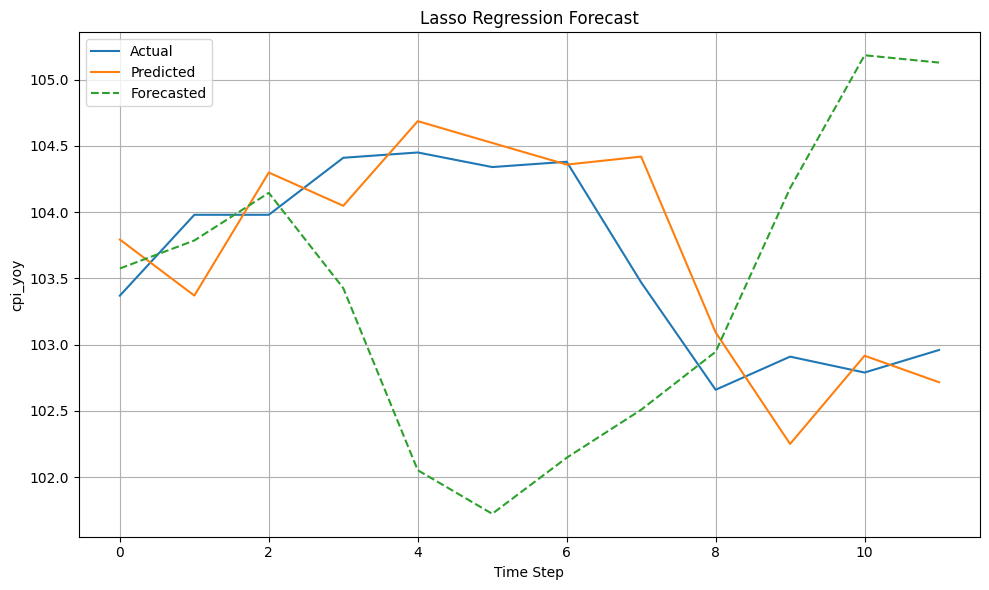

Best Params: {'alpha': 0.001, 'l1_ratio': 0.1}
Prediction Metrics (Test Set):
RMSE: 0.4274
MAE: 0.3288
MAPE: 0.34%

Forecast Metrics:
RMSE: 1.6498
MAE: 1.0425
MAPE: 1.29%


C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2875198722.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2875198722.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2875198722.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2875198722.py:61:

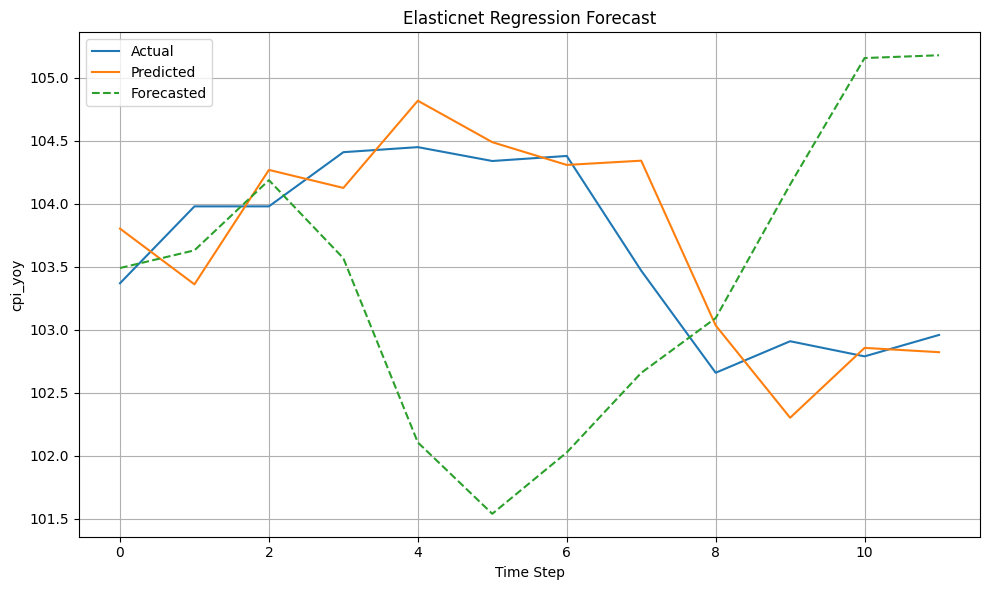

(array([103.80359584, 103.3615552 , 104.26933892, 104.12647927,
        104.81827654, 104.48935521, 104.30888382, 104.34254919,
        103.03553973, 102.3030532 , 102.85727177, 102.82306645]),
 array([103.49078964, 103.63121118, 104.18792694, 103.56839247,
        102.10701778, 101.54094637, 102.02761624, 102.65897767,
        103.09372763, 104.15330711, 105.15688296, 105.17895517]))

In [11]:
# Linear Regression
lr_forecaster = LinearModelForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_yoy', model_type='linear')
lr_forecaster.run()

# Ridge Regression
ridge_forecaster = LinearModelForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_yoy', model_type='ridge')
ridge_forecaster.run()

# Lasso Regression
lasso_forecaster = LinearModelForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_yoy', model_type='lasso')
lasso_forecaster.run()

# ElasticNet Regression
enet_forecaster = LinearModelForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_yoy', model_type='elasticnet')
enet_forecaster.run()


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.model_selection import RandomizedSearchCV


class RandomForestForecaster:
    def __init__(self, data_path, target_col, lags=list(range(1, 13))):
        self.data_path = data_path
        self.target_col = target_col
        self.lags = lags
        self.df = None
        self.scaler = StandardScaler()
        self.model = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.predictions = None

    def load_data(self):
        try:
            self.df = pd.read_csv(self.data_path, parse_dates=['time'], index_col='time')
            self.df[self.target_col] = self.scaler.fit_transform(self.df[[self.target_col]])
            for lag in self.lags:
                self.df[f'lag_{lag}'] = self.df[self.target_col].shift(lag)
            self.df = self.df.dropna()
        except FileNotFoundError:
            print(f"Error: File {self.data_path} not found")
            raise
        except KeyError:
            print(f"Error: Column 'time' or '{self.target_col}' not found in the data")
            raise

    def prepare_data(self, test_size=12):
        features = self.df[[f'lag_{lag}' for lag in self.lags]].values
        target = self.df[self.target_col].values
        self.X_train, self.X_test = features[:-test_size], features[-test_size:]
        self.y_train, self.y_test = target[:-test_size], target[-test_size:]
        return self.X_train, self.X_test, self.y_train, self.y_test

    def tune_hyperparameters(self):
        param_distributions = {
            'n_estimators': [50, 100, 150, 200],
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        rf = RandomForestRegressor(random_state=42)
        search = RandomizedSearchCV(
            rf,
            param_distributions=param_distributions,
            n_iter=20,
            scoring='neg_mean_squared_error',
            cv=3,
            verbose=1,
            n_jobs=-1,
            random_state=42
        )
        search.fit(self.X_train, self.y_train)
        print("Best Parameters:", search.best_params_)
        return search.best_estimator_

    def forecast(self, steps=12, start_sequence=None):
        if self.model is None:
            raise ValueError("Model not trained. Run `run()` first.")
        if start_sequence is None:
            raise ValueError("Start sequence must be provided.")
        sequence = start_sequence.copy().flatten()
        forecasts = []
        for _ in range(steps):
            pred = self.model.predict(sequence.reshape(1, -1))
            forecasts.append(pred[0])
            sequence = np.roll(sequence, -1)
            sequence[-1] = pred
        forecasts = np.array(forecasts)
        return self.scaler.inverse_transform(forecasts.reshape(-1, 1)).flatten()

    def plot_results(self, y_test, predictions, forecasts, test_size=12):
        plt.figure(figsize=(12, 6))
        plt.plot(range(test_size), y_test, label='Actual', color='blue')
        plt.plot(range(test_size), predictions, label='Predicted', color='orange')
        plt.plot(range(test_size), forecasts, label='Forecasted', color='green', linestyle='--')
        plt.title('Actual, Predicted, and Forecasted CPI YoY over Test Period')
        plt.xlabel('Time Step')
        plt.ylabel('CPI YoY')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def run(self, test_size=12):
        self.load_data()
        self.X_train, self.X_test, self.y_train, self.y_test = self.prepare_data(test_size)
        self.model = self.tune_hyperparameters()
        self.model.fit(self.X_train, self.y_train)
        self.predictions = self.model.predict(self.X_test)
        predictions = self.scaler.inverse_transform(self.predictions.reshape(-1, 1)).flatten()
        y_test = self.scaler.inverse_transform(self.y_test.reshape(-1, 1)).flatten()
        forecasts = self.forecast(steps=test_size, start_sequence=self.X_train[-1:])
        
        # Evaluation: Predictions
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = median_absolute_error(y_test, predictions)
        mape = mean_absolute_percentage_error(y_test, predictions) * 100
        print("Prediction Metrics (Test Set):")
        print(f"RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

        # Evaluation: Forecasts
        mse_f = mean_squared_error(y_test, forecasts)
        rmse_f = np.sqrt(mse_f)
        mae_f = median_absolute_error(y_test, forecasts)
        mape_f = mean_absolute_percentage_error(y_test, forecasts) * 100
        print("\nForecast Metrics (Test Period):")
        print(f"RMSE: {rmse_f:.4f}, MSE: {mse_f:.4f}, MAE: {mae_f:.4f}, MAPE: {mape_f:.2f}%")

        self.plot_results(y_test, predictions, forecasts, test_size)
        return predictions, forecasts


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10}


C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\1570514725.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\1570514725.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\1570514725.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\1570514725.py:78:

Prediction Metrics (Test Set):
RMSE: 0.4473, MSE: 0.2001, MAE: 0.3101, MAPE: 0.35%

Forecast Metrics (Test Period):
RMSE: 1.2680, MSE: 1.6079, MAE: 0.9945, MAPE: 1.00%


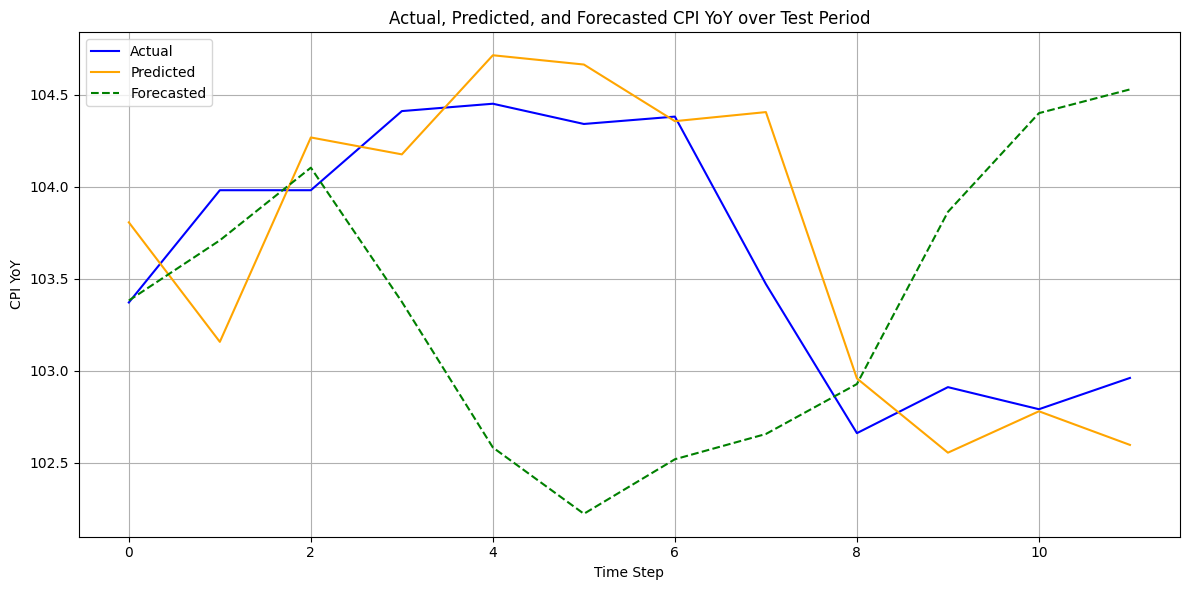

In [19]:
forecaster = RandomForestForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_yoy')
predictions, forecasts = forecaster.run(test_size=12)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10}


C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\1570514725.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\1570514725.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\1570514725.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\1570514725.py:78:

Prediction Metrics (Test Set):
RMSE: 0.3607, MSE: 0.1301, MAE: 0.1454, MAPE: 0.25%

Forecast Metrics (Test Period):
RMSE: 0.4730, MSE: 0.2237, MAE: 0.2690, MAPE: 0.36%


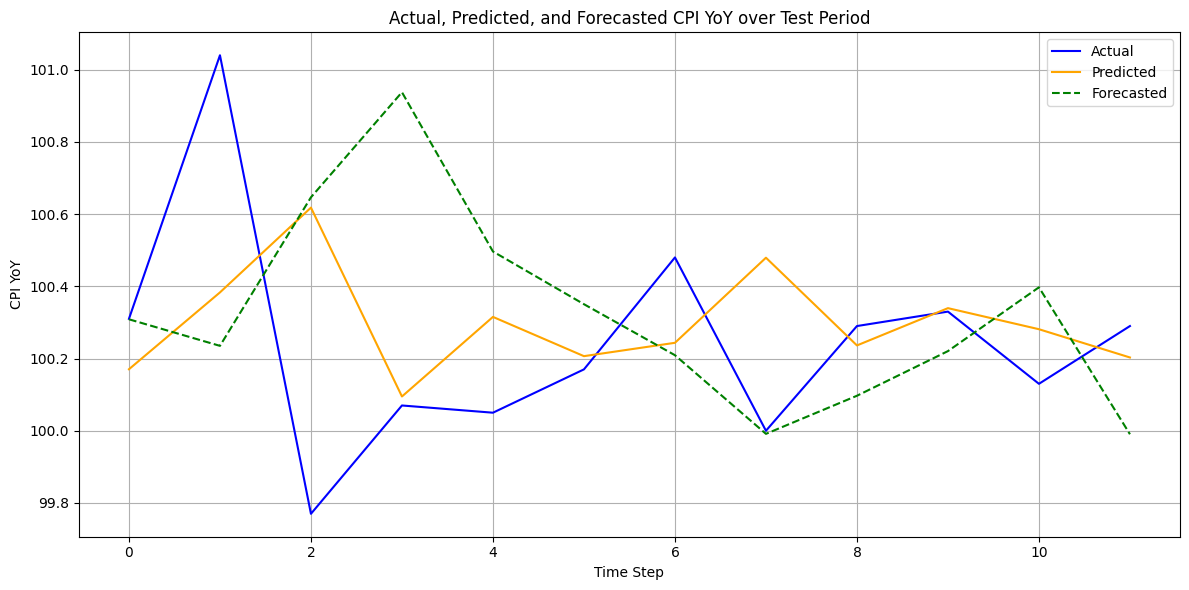

In [5]:
forecaster = RandomForestForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_mom')
predictions, forecasts = forecaster.run(test_size=12)


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor


class XGBoostForecaster:
    def __init__(self, data_path, target_col, lags=list(range(1, 13))):
        self.data_path = data_path
        self.target_col = target_col
        self.lags = lags
        self.df = None
        self.scaler = StandardScaler()
        self.model = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.predictions = None

    def load_data(self):
        try:
            self.df = pd.read_csv(self.data_path, parse_dates=['time'], index_col='time')
            self.df[self.target_col] = self.scaler.fit_transform(self.df[[self.target_col]])
            for lag in self.lags:
                self.df[f'lag_{lag}'] = self.df[self.target_col].shift(lag)
            self.df = self.df.dropna()
        except Exception as e:
            print(f"Error loading data: {e}")
            raise

    def prepare_data(self, test_size=12):
        features = self.df[[f'lag_{lag}' for lag in self.lags]].values
        target = self.df[self.target_col].values
        self.X_train, self.X_test = features[:-test_size], features[-test_size:]
        self.y_train, self.y_test = target[:-test_size], target[-test_size:]
        return self.X_train, self.X_test, self.y_train, self.y_test

    def tune_hyperparameters(self):
        param_distributions = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7, 10],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.7, 0.8, 1.0],
            'colsample_bytree': [0.7, 0.9, 1.0],
            'gamma': [0, 0.1, 0.2]
        }
        xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
        search = RandomizedSearchCV(
            xgb,
            param_distributions=param_distributions,
            n_iter=20,
            scoring='neg_mean_squared_error',
            cv=3,
            verbose=1,
            n_jobs=-1,
            random_state=42
        )
        search.fit(self.X_train, self.y_train)
        print("Best Parameters:", search.best_params_)
        return search.best_estimator_

    def forecast(self, steps=12, start_sequence=None):
        if self.model is None:
            raise ValueError("Model not trained. Run `run()` first.")
        if start_sequence is None:
            raise ValueError("Start sequence must be provided.")
        sequence = start_sequence.copy().flatten()
        forecasts = []
        for _ in range(steps):
            pred = self.model.predict(sequence.reshape(1, -1))
            forecasts.append(pred[0])
            sequence = np.roll(sequence, -1)
            sequence[-1] = pred
        forecasts = np.array(forecasts)
        return self.scaler.inverse_transform(forecasts.reshape(-1, 1)).flatten()

    def plot_results(self, y_test, predictions, forecasts, test_size=12):
        plt.figure(figsize=(12, 6))
        plt.plot(range(test_size), y_test, label='Actual', color='blue')
        plt.plot(range(test_size), predictions, label='Predicted', color='orange')
        plt.plot(range(test_size), forecasts, label='Forecasted', color='green', linestyle='--')
        plt.title('Actual, Predicted, and Forecasted CPI YoY over Test Period')
        plt.xlabel('Time Step')
        plt.ylabel('CPI YoY')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def run(self, test_size=12):
        self.load_data()
        self.prepare_data(test_size)
        self.model = self.tune_hyperparameters()
        self.model.fit(self.X_train, self.y_train)
        self.predictions = self.model.predict(self.X_test)
        predictions = self.scaler.inverse_transform(self.predictions.reshape(-1, 1)).flatten()
        y_test = self.scaler.inverse_transform(self.y_test.reshape(-1, 1)).flatten()
        forecasts = self.forecast(steps=test_size, start_sequence=self.X_train[-1:])
        
        # Evaluation
        # Evaluation: Predictions
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = median_absolute_error(y_test, predictions)
        mape = mean_absolute_percentage_error(y_test, predictions) * 100
        print("Prediction Metrics (Test Set):")
        print(f"RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

        # Evaluation: Forecasts
        mse_f = mean_squared_error(y_test, forecasts)
        rmse_f = np.sqrt(mse_f)
        mae_f = median_absolute_error(y_test, forecasts)
        mape_f = mean_absolute_percentage_error(y_test, forecasts) * 100
        print("\nForecast Metrics (Test Period):")
        print(f"RMSE: {rmse_f:.4f}, MSE: {mse_f:.4f}, MAE: {mae_f:.4f}, MAPE: {mape_f:.2f}%")

        self.plot_results(y_test, predictions, forecasts, test_size)
        return predictions, forecasts


Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\ASUS\anaconda3\envs\python39\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
3 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ASUS\anaconda3\envs\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ASUS\anaconda3\envs\python39\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\ASUS\anaconda3\envs\python39\lib\site-packages\xgboost\sklearn.py", line 1143, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(


Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.9}


C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\454450239.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred


Prediction Metrics (Test Set):
RMSE: 0.4461, MSE: 0.1990, MAE: 0.2560, MAPE: 0.35%

Forecast Metrics (Test Period):
RMSE: 1.3146, MSE: 1.7282, MAE: 1.3603, MAPE: 1.08%


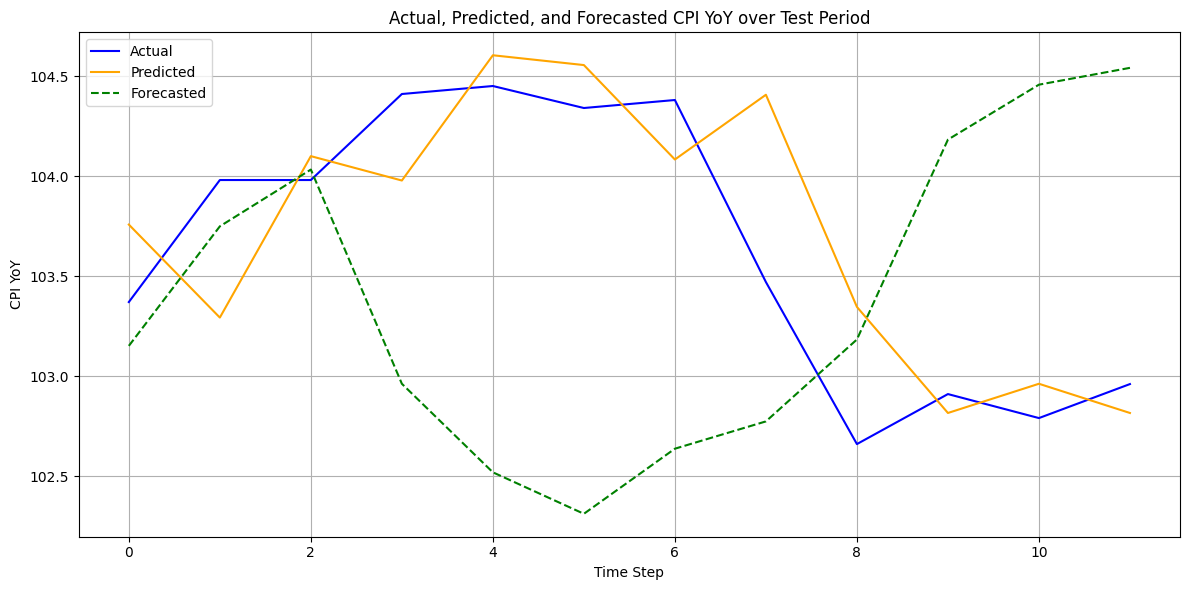

In [8]:
forecaster = XGBoostForecaster(data_path="data/analyzed_time_series.csv", target_col="cpi_yoy")
predictions, forecasts = forecaster.run(test_size=12)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 1.0}
Prediction Metrics (Test Set):
RMSE: 0.3863, MSE: 0.1492, MAE: 0.1467, MAPE: 0.26%

Forecast Metrics (Test Period):
RMSE: 0.4690, MSE: 0.2199, MAE: 0.2474, MAPE: 0.35%


C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\454450239.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred


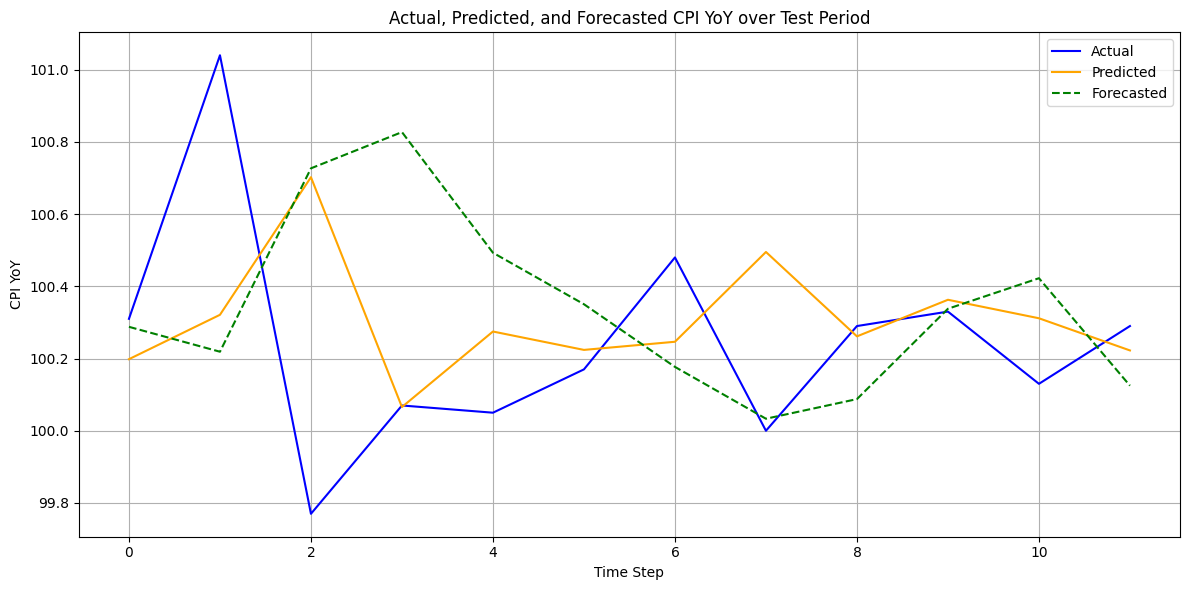

In [9]:
forecaster = XGBoostForecaster(data_path="data/analyzed_time_series.csv", target_col="cpi_mom")
predictions, forecasts = forecaster.run(test_size=12)


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

class LGBMForecaster:
    def __init__(self, data_path, target_col, lags=list(range(1,13)), random_search=False):
        self.data_path = data_path
        self.target_col = target_col
        self.lags = lags
        self.random_search = random_search
        self.df = None
        self.scaler = StandardScaler()
        self.model = None
        self.X_train = self.X_test = self.y_train = self.y_test = None

    def load_data(self):
        self.df = pd.read_csv(self.data_path, parse_dates=['time'], index_col='time')
        self.df[self.target_col] = self.scaler.fit_transform(self.df[[self.target_col]])
        for lag in self.lags:
            self.df[f'lag_{lag}'] = self.df[self.target_col].shift(lag)
        self.df.dropna(inplace=True)

    def prepare_data(self, test_size=12):
        X = self.df[[f'lag_{lag}' for lag in self.lags]].values
        y = self.df[self.target_col].values
        self.X_train, self.X_test = X[:-test_size], X[-test_size:]
        self.y_train, self.y_test = y[:-test_size], y[-test_size:]

    def build_model(self):
        base_model = LGBMRegressor(random_state=42, verbose=-1)
        if self.random_search:
            param_dist = {
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 7, -1],
                'learning_rate': [0.01, 0.05, 0.1],
                'subsample': [0.7, 0.8, 1.0],
                'colsample_bytree': [0.7, 0.8, 1.0]
            }
            model = RandomizedSearchCV(
                base_model, param_distributions=param_dist,
                n_iter=20, scoring='neg_mean_squared_error',
                cv=3, random_state=42, verbose=1
            )
        else:
            model = base_model
        return model

    def forecast(self, steps=12, start_sequence=None):
        if self.model is None:
            raise ValueError("Model not trained. Run `run()` first.")
        if start_sequence is None:
            raise ValueError("Start sequence must be provided.")
        sequence = start_sequence.flatten()
        forecasts = []
        for _ in range(steps):
            pred = self.model.predict(sequence.reshape(1, -1))
            forecasts.append(pred[0])
            sequence = np.roll(sequence, -1)
            sequence[-1] = pred
        return self.scaler.inverse_transform(np.array(forecasts).reshape(-1, 1)).flatten()

    def plot_results(self, y_test, predictions, forecasts):
        plt.figure(figsize=(10, 6))
        plt.plot(y_test, label='Actual')
        plt.plot(predictions, label='Predicted')
        plt.plot(forecasts, label='Forecasted', linestyle='--')
        plt.title('LGBM Forecast')
        plt.xlabel('Time Step')
        plt.ylabel(self.target_col)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def run(self, test_size=12):
        self.load_data()
        self.prepare_data(test_size)
        self.model = self.build_model()
        self.model.fit(self.X_train, self.y_train)
        if hasattr(self.model, 'best_params_'):
            print("Best Params:", self.model.best_params_)

        predictions = self.model.predict(self.X_test)
        y_test_actual = self.scaler.inverse_transform(self.y_test.reshape(-1, 1)).flatten()
        predictions_actual = self.scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
        forecasts = self.forecast(steps=test_size, start_sequence=self.X_train[-1:])

        # Evaluation
        print("Prediction Metrics (Test Set):")
        print(f"RMSE: {np.sqrt(mean_squared_error(y_test_actual, predictions_actual)):.4f}")
        print(f"MAE: {median_absolute_error(y_test_actual, predictions_actual):.4f}")
        print(f"MAPE: {mean_absolute_percentage_error(y_test_actual, predictions_actual) * 100:.2f}%")

        print("\nForecast Metrics:")
        print(f"RMSE: {np.sqrt(mean_squared_error(y_test_actual, forecasts)):.4f}")
        print(f"MAE: {median_absolute_error(y_test_actual, forecasts):.4f}")
        print(f"MAPE: {mean_absolute_percentage_error(y_test_actual, forecasts) * 100:.2f}%")

        self.plot_results(y_test_actual, predictions_actual, forecasts)
        return predictions_actual, forecasts


c:\Users\ASUS\anaconda3\envs\python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\3815677779.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
c:\Users\ASUS\anaconda3\envs\python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\3815677779.py:63: Deprec

Prediction Metrics (Test Set):
RMSE: 0.5854
MAE: 0.4069
MAPE: 0.47%

Forecast Metrics:
RMSE: 1.2899
MAE: 1.0236
MAPE: 1.07%


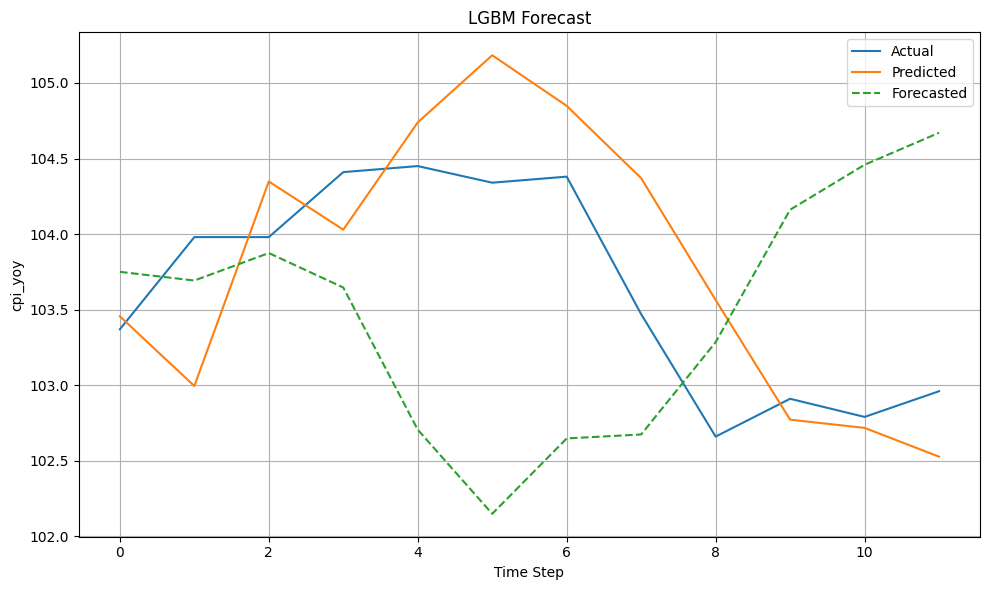

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\ASUS\anaconda3\envs\python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with featur

Best Params: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Prediction Metrics (Test Set):
RMSE: 0.4797
MAE: 0.2412
MAPE: 0.36%

Forecast Metrics:
RMSE: 1.2680
MAE: 1.0807
MAPE: 1.03%


c:\Users\ASUS\anaconda3\envs\python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\3815677779.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
c:\Users\ASUS\anaconda3\envs\python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\3815677779.py:63: Deprec

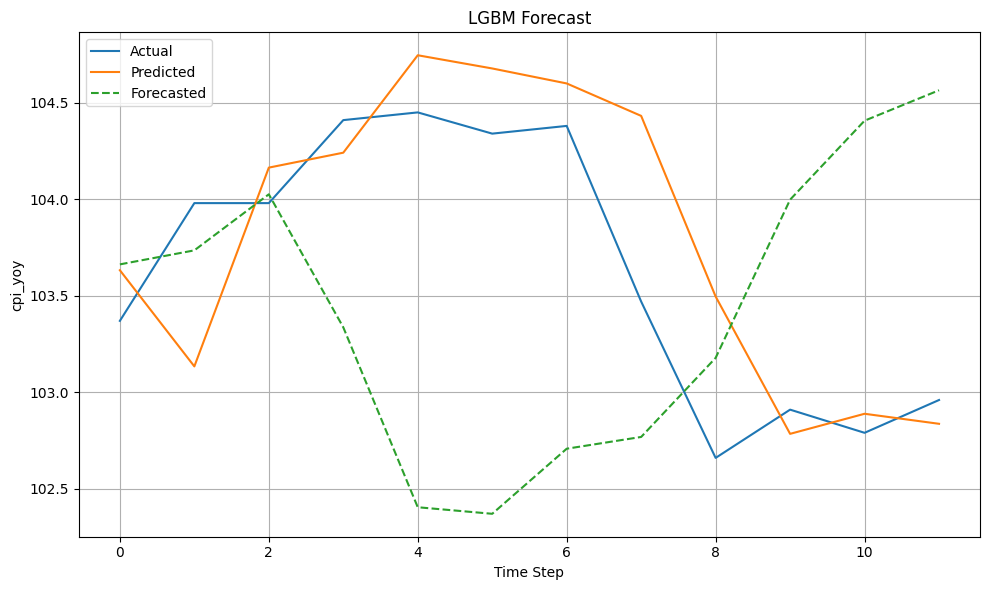

(array([103.63234826, 103.13408241, 104.16390761, 104.24128141,
        104.74602792, 104.67762392, 104.60000604, 104.43193677,
        103.49609622, 102.78464219, 102.88863902, 102.83666579]),
 array([103.6626098 , 103.73522969, 104.02565339, 103.33645345,
        102.40439224, 102.370424  , 102.70755578, 102.76854033,
        103.17820734, 103.99787341, 104.40703516, 104.56468587]))

In [13]:
# Dự báo với LGBM không tối ưu tham số
lgbm_forecaster = LGBMForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_yoy')
lgbm_forecaster.run()

# Dự báo với LGBM và RandomizedSearchCV
lgbm_tuned_forecaster = LGBMForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_yoy', random_search=True)
lgbm_tuned_forecaster.run()


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error

class SVRForecaster:
    def __init__(self, data_path, target_col, lags=list(range(1,13)), random_search=False):
        self.data_path = data_path
        self.target_col = target_col
        self.lags = lags
        self.random_search = random_search
        self.df = None
        self.scaler = StandardScaler()
        self.model = None
        self.X_train = self.X_test = self.y_train = self.y_test = None

    def load_data(self):
        self.df = pd.read_csv(self.data_path, parse_dates=['time'], index_col='time')
        self.df[self.target_col] = self.scaler.fit_transform(self.df[[self.target_col]])
        for lag in self.lags:
            self.df[f'lag_{lag}'] = self.df[self.target_col].shift(lag)
        self.df.dropna(inplace=True)

    def prepare_data(self, test_size=12):
        X = self.df[[f'lag_{lag}' for lag in self.lags]].values
        y = self.df[self.target_col].values
        self.X_train, self.X_test = X[:-test_size], X[-test_size:]
        self.y_train, self.y_test = y[:-test_size], y[-test_size:]

    def build_model(self):
        base_model = SVR()
        if self.random_search:
            param_grid = {
                'C': [0.1, 1, 10, 100],
                'epsilon': [0.01, 0.1, 0.2],
                'kernel': ['rbf', 'linear', 'poly'],
                'gamma': ['scale', 'auto']
            }
            model = RandomizedSearchCV(
                base_model,
                param_distributions=param_grid,
                n_iter=15,
                scoring='neg_mean_squared_error',
                cv=3,
                random_state=42,
                verbose=1
            )
        else:
            model = base_model
        return model

    def forecast(self, steps=12, start_sequence=None):
        if self.model is None:
            raise ValueError("Model not trained. Run `run()` first.")
        if start_sequence is None:
            raise ValueError("Start sequence must be provided.")
        sequence = start_sequence.flatten()
        forecasts = []
        for _ in range(steps):
            pred = self.model.predict(sequence.reshape(1, -1))
            forecasts.append(pred[0])
            sequence = np.roll(sequence, -1)
            sequence[-1] = pred
        return self.scaler.inverse_transform(np.array(forecasts).reshape(-1, 1)).flatten()

    def plot_results(self, y_test, predictions, forecasts):
        plt.figure(figsize=(10, 6))
        plt.plot(y_test, label='Actual')
        plt.plot(predictions, label='Predicted')
        plt.plot(forecasts, label='Forecasted', linestyle='--')
        plt.title('SVR Forecast')
        plt.xlabel('Time Step')
        plt.ylabel(self.target_col)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def run(self, test_size=12):
        self.load_data()
        self.prepare_data(test_size)
        self.model = self.build_model()
        self.model.fit(self.X_train, self.y_train)
        if hasattr(self.model, 'best_params_'):
            print("Best Params:", self.model.best_params_)

        predictions = self.model.predict(self.X_test)
        y_test_actual = self.scaler.inverse_transform(self.y_test.reshape(-1, 1)).flatten()
        predictions_actual = self.scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
        forecasts = self.forecast(steps=test_size, start_sequence=self.X_train[-1:])

        print("Prediction Metrics (Test Set):")
        print(f"RMSE: {np.sqrt(mean_squared_error(y_test_actual, predictions_actual)):.4f}")
        print(f"MAE: {median_absolute_error(y_test_actual, predictions_actual):.4f}")
        print(f"MAPE: {mean_absolute_percentage_error(y_test_actual, predictions_actual) * 100:.2f}%")

        print("\nForecast Metrics:")
        print(f"RMSE: {np.sqrt(mean_squared_error(y_test_actual, forecasts)):.4f}")
        print(f"MAE: {median_absolute_error(y_test_actual, forecasts):.4f}")
        print(f"MAPE: {mean_absolute_percentage_error(y_test_actual, forecasts) * 100:.2f}%")

        self.plot_results(y_test_actual, predictions_actual, forecasts)
        return predictions_actual, forecasts


Prediction Metrics (Test Set):
RMSE: 0.4207
MAE: 0.2138
MAPE: 0.29%

Forecast Metrics:
RMSE: 1.4275
MAE: 1.3815
MAPE: 1.17%


C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2832561066.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2832561066.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2832561066.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2832561066.py:66:

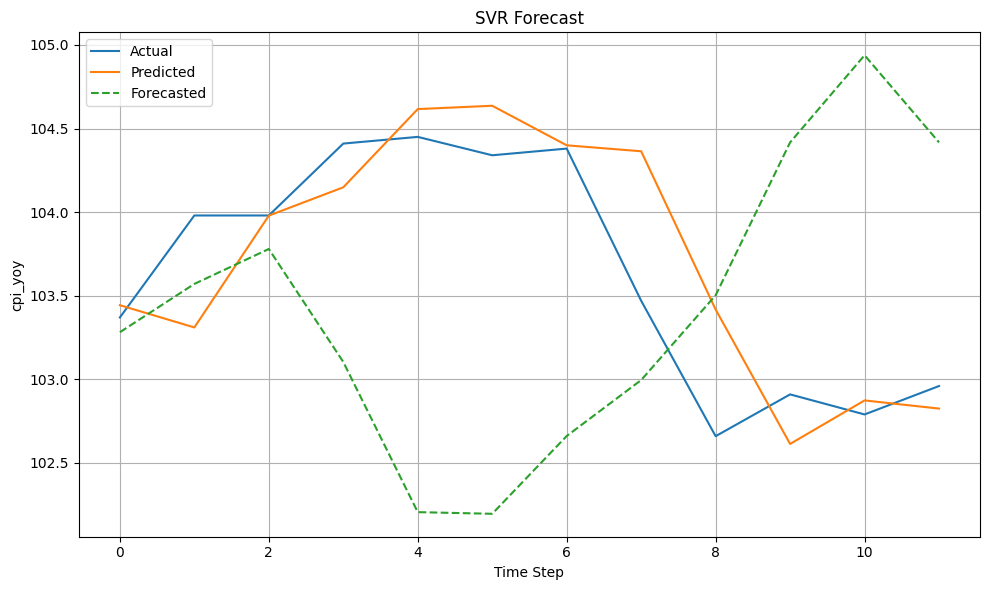

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Params: {'kernel': 'linear', 'gamma': 'auto', 'epsilon': 0.1, 'C': 1}
Prediction Metrics (Test Set):
RMSE: 0.4249
MAE: 0.3316
MAPE: 0.34%

Forecast Metrics:
RMSE: 1.6393
MAE: 1.0160
MAPE: 1.28%


C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2832561066.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2832561066.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2832561066.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sequence[-1] = pred
C:\Users\ASUS\AppData\Local\Temp\ipykernel_772608\2832561066.py:66:

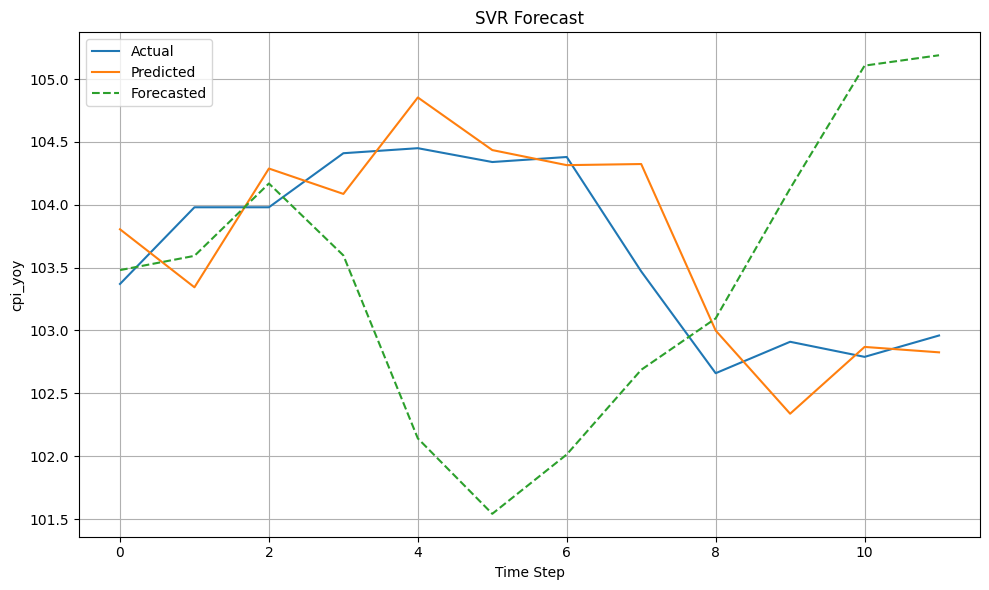

(array([103.8048853 , 103.34344371, 104.28821447, 104.08625981,
        104.85357025, 104.43504678, 104.31515474, 104.32403411,
        102.99954464, 102.33771592, 102.86906303, 102.82599829]),
 array([103.48023501, 103.5935279 , 104.16914546, 103.59711345,
        102.14136741, 101.54156594, 102.01348824, 102.68703248,
        103.09591177, 104.12913924, 105.1068971 , 105.18931516]))

In [15]:
# SVR bình thường
svr_forecaster = SVRForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_yoy')
svr_forecaster.run()

# SVR có RandomizedSearchCV
svr_tuned = SVRForecaster(data_path="data/analyzed_time_series.csv", target_col='cpi_yoy', random_search=True)
svr_tuned.run()
